# Two coupled Duffing Oscillators

In [42]:
using DrWatson # a scientific project assistant package. It helps managing scientific projects, e.g., reproducibility, data analysis, etc.
@quickactivate "KerrDimer"

using HarmonicBalance; HB = HarmonicBalance # A package for solving the complete solution space of nonlinear oscillatros
using Symbolics
import HarmonicBalance.LinearResponse.plot_linear_response # The linear reponse module of HB

using Plots, Measures, LaTeXStrings, Latexify # Plotting tools
using Logging; Logging.disable_logging(Logging.Warn); # Gets rid of the annoying "Warning: non-negligible complex parts have been projected on the real axis" message

Base.atan(v::ComplexF64, u::ComplexF64) = atan(real(v), real(u)) # To make a phase plot
# ^ the solutions of the HB method are of the type ComplexF64 (only the real are physical). This is a quick fix.

ArgumentError: ArgumentError: Package Latexify not found in current path.
- Run `import Pkg; Pkg.add("Latexify")` to install the Latexify package.

In [2]:
Threads.nthreads()

10

## The system

\begin{equation}

\end{equation}

### Mean-field

Hot fix required for the eom field in the harmonic equations object to not be empty. Will be corrected in future versions

In [3]:
# defining variables
@variables T t x(t) y(t)
@variables u1(T)::Real v1(T)::Real u2(T)::Real v2(T)::Real
@variables κ₁::Real κ₂::Real F_1::Real J::Real ω_1::Real ω_2::Real U_1::Real U_2::Real ω_p::Real 
@variables α₁::Complex{Real} α₂::Complex{Real}

# accounting for the fact that we "divide" each complex equation in its real and imaginary part
function replace_split(f, sub_rules)
    exp = substitute(real(f), sub_rules) + 1.0im*substitute(imag(f), sub_rules)
    [real(exp), imag(exp)]
end

function get_EOM_full()
    K₁ = (-(ω_p-ω_1) + U_1*conj(α₁)*α₁ - 1.0im*κ₁/2)*α₁ + F_1
    #*sqrt(U)
    K₂ = (-(ω_p-ω_2) + U_2*conj(α₂)*α₂ - 1.0im*κ₂/2)*α₂

    fψ₁ =   -1.0im*(K₁ - J*α₂)
    fψ₂ =   -1.0im*(K₂ - J*α₁)

    sub_rules = Dict((real(α₁) => u1), (imag(α₁) => v1), (real(α₂) => u2), (imag(α₂) => v2))
    system_f= reduce(vcat,[replace_split(f,sub_rules) for f in [fψ₁,fψ₂]])

    variables = [
        HarmonicVariable(u1, "u_{x,ω_p}", "u", ω_p, x),
        HarmonicVariable(v1, "v_{x,ω_p}", "v", ω_p, x),
        HarmonicVariable(u2, "u_{y,ω_p}", "u", ω_p, y),
        HarmonicVariable(v2, "v_{y,ω_p}", "v", ω_p, y)
    ]
    parameters = [ω_1, ω_2, ω_p, U_1, U_2, F_1, J, κ₁, κ₂]
    dummy_eq = DifferentialEquation([d(x,t,2) + ω_1^2*x ~ 0, d(y,t,2) + ω_2^2*y ~ 0], [x, y])

    equation_HC = HarmonicBalance.HarmonicEquation(system_f.~0,variables,parameters, dummy_eq);
    return equation_HC
end

MF_eqs = get_EOM_full();

In [4]:
MF_eqs.equations

4-element Vector{Equation}:
 (ω_1 + U_1*(u1(T)^2) + U_1*(v1(T)^2) - ω_p)*v1(T) - 0.5κ₁*u1(T) - J*v2(T) ~ 0
 J*u2(T) - F_1 - (ω_1 + U_1*(u1(T)^2) + U_1*(v1(T)^2) - ω_p)*u1(T) - 0.5κ₁*v1(T) ~ 0
 (ω_2 + U_2*(u2(T)^2) + U_2*(v2(T)^2) - ω_p)*v2(T) - 0.5κ₂*u2(T) - J*v1(T) ~ 0
 J*u1(T) + (ω_p - ω_2 - U_2*(u2(T)^2) - U_2*(v2(T)^2))*u2(T) - 0.5κ₂*v2(T) ~ 0

In [5]:
## Experimental parameters
omega_1_exp = 7270; omega_2_exp = 7304
kappa_1_exp = 14.2; kappa_2_exp = 13.8
U_1_exp = -7.3; U_2_exp = -6.7
# x1_min_exp=2*pi*7000; x1_max_exp=2*pi*7200
# kappa_exp=0.5;
 J_exp=43.6;

In [6]:
# Dimensional parameters
@show omega_1 = omega_1_exp/omega_1_exp
@show omega_2 = omega_2_exp/omega_1_exp
@show U_1_val = U_1_exp/omega_1_exp
@show U_2_val = U_2_exp/omega_1_exp
@show kappa_1 = kappa_1_exp/omega_1_exp
@show kappa_2 = kappa_2_exp/omega_1_exp
# x1_min = x1_min_exp/omega_1_exp
# x1_max =x1_max_exp/omega_1_exp
@show J_val = J_exp/omega_1_exp

ω_p_min = 0.5; ω_p_max = 1.1;

omega_1 = omega_1_exp / omega_1_exp = 1.0
omega_2 = omega_2_exp / omega_1_exp = 1.0046767537826684
U_1_val = U_1_exp / omega_1_exp = -0.0010041265474552957
U_2_val = U_2_exp / omega_1_exp = -0.000921595598349381
kappa_1 = kappa_1_exp / omega_1_exp = 0.001953232462173315


kappa_2 = kappa_2_exp / omega_1_exp = 0.0018982118294360386
J_val = J_exp / omega_1_exp = 0.005997248968363136


## Bifurcation diagram

In [7]:
# differential equations
diff_eq = DifferentialEquation([d(x,t,2) + ω_1^2*x ~ 0,
                                d(y,t,2) + ω_2^2*y ~ 0], [x,y])

# specify the harmonic ansatz for x and y: x = u(T) cos(ωt) + v(T) sin(ωt)
add_harmonic!(diff_eq, x, ω_p)
add_harmonic!(diff_eq, y, ω_p)

# implement ansatz to get harmonic equations
harmonic_eq_dummy = get_harmonic_equations(diff_eq)

A set of 4 harmonic equations
Variables: u1(T), v1(T), u2(T), v2(T)
Parameters: ω_1, ω_p, ω_2

Harmonic ansatz: 
x(t) = u1(T)*cos(ω_pt) + v1(T)*sin(ω_pt)
y(t) = u2(T)*cos(ω_pt) + v2(T)*sin(ω_pt)

Harmonic equations:

(ω_1^2)*u1(T) + (2//1)*ω_p*Differential(T)(v1(T)) - (ω_p^2)*u1(T) ~ 0

(ω_1^2)*v1(T) - (2//1)*ω_p*Differential(T)(u1(T)) - (ω_p^2)*v1(T) ~ 0

(ω_2^2)*u2(T) + (2//1)*ω_p*Differential(T)(v2(T)) - (ω_p^2)*u2(T) ~ 0

(ω_2^2)*v2(T) - (2//1)*ω_p*Differential(T)(u2(T)) - (ω_p^2)*v2(T) ~ 0


In [8]:
fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1 => omega_1, ω_2 => omega_2, U_1 => U_1_val, U_2 => U_2_val, J => J_val)
varied = (ω_p=> range(ω_p_min, ω_p_max, 100), F_1 => 10 .^range(-5, 1, 100))

# results
result_ωF = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true, random_warmup=false)

A steady state result for 10000 parameter points

Solution branches:   9
   of which real:    9
   of which stable:  7

Classes: stable, physical, Hopf, binary_labels


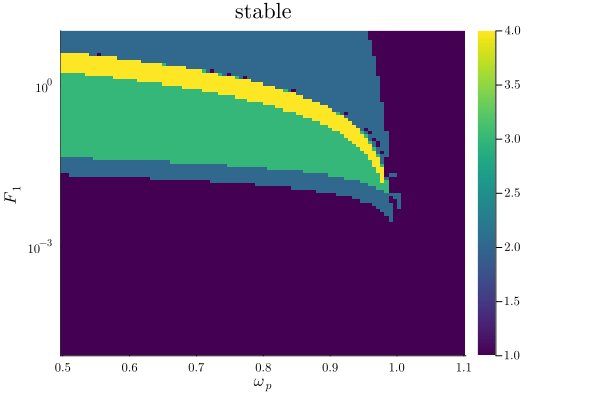

In [9]:
# p1 = plot_phase_diagram(result, title="all", clim =(0,5), yaxis=:log)
p2 = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log)
# p3 = plot_phase_diagram(result, not_class="stable", title="unstable", clim =(0,5), yaxis=:log)
# p_MF = plot([p1,p2,p3]..., layout = (1,3), size = (1200,250), margin = 5mm)

In [10]:
# fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val)
# varied = (ω_p=> range(0.85, 1.15, 50), F_1 => 14 .^range(-5, 3, 50))

# # results
# result_tmp = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true, random_warmup=false)

# plot_phase_diagram(result_tmp, class="stable", title="stable", yaxis=:log)

## Amplitude plot

#### linear

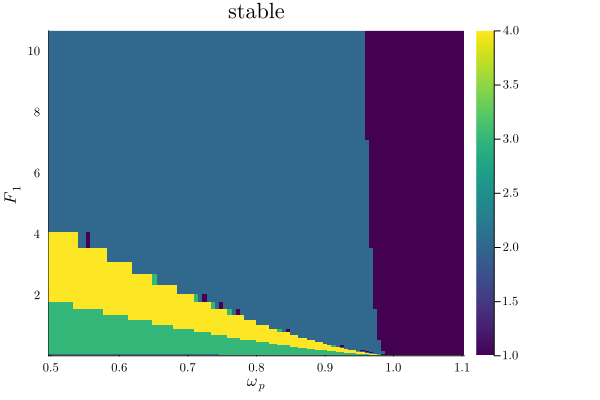

In [11]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:linear)

Computing mixed cells... 2 	 Time: 0:00:00
  mixed_volume:  21

Computing mixed cells... 6 	 Time: 0:00:00
  mixed_volume:  81


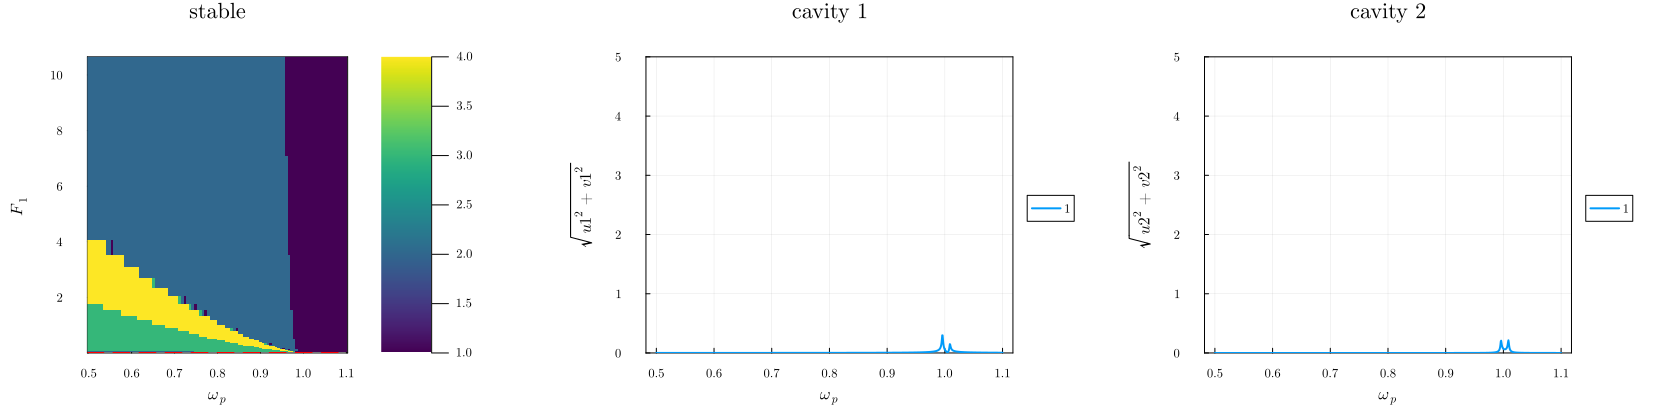

In [12]:
f_cut = 0.00044; yscale = :linear; class = "stable"; ymax = 5

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "√(u1^2+v1^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1")
p3 = plot(result_ω1, y = "√(u2^2+v2^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

[Antiresoncance](https://en.wikipedia.org/wiki/Antiresonance)

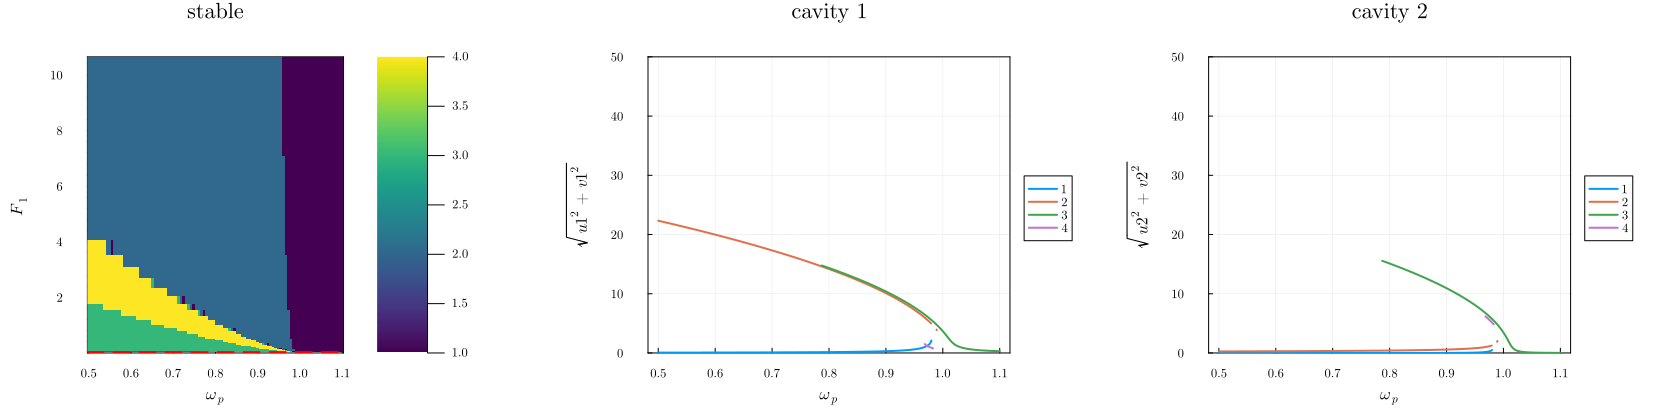

In [13]:
f_cut = 0.03; yscale = :linear; class = "stable"; ymax=50

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=true)
p2 = plot(result_ω1, y = "√(u1^2+v1^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1")
p3 = plot(result_ω1, y = "√(u2^2+v2^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

#### log

In [14]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log);

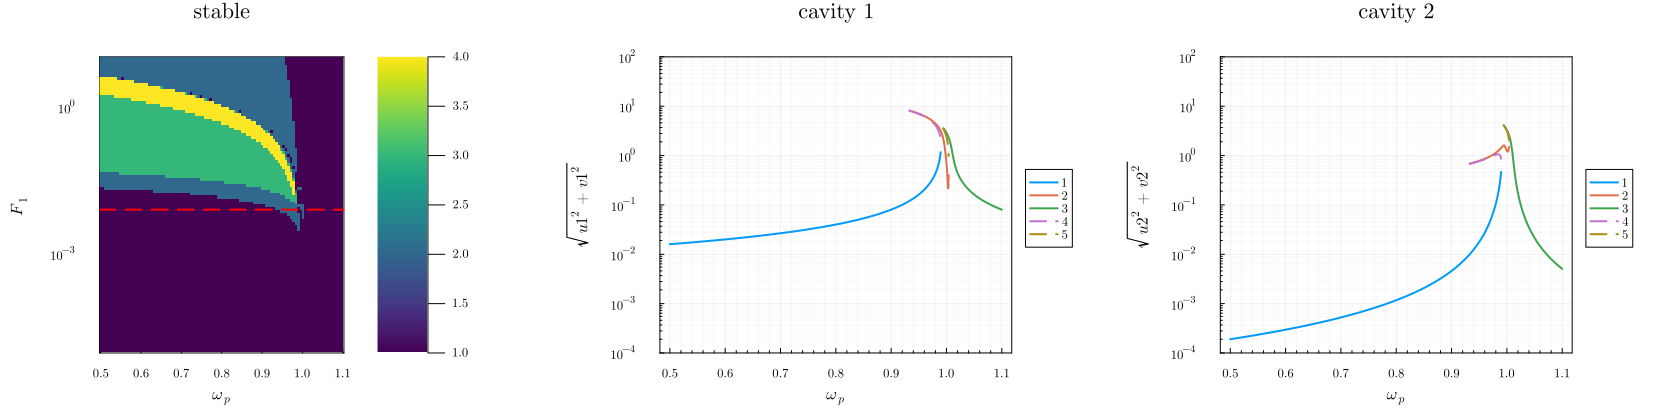

In [15]:
f_cut = 0.008; yscale = :log10; class = "default"; ymax = 100

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=10)
p2 = plot(result_ω1, y = "√(u1^2+v1^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-4,ymax), yminorticks=10, minorgrid=true, title="cavity 1")
p3 = plot(result_ω1, y = "√(u2^2+v2^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-4,ymax), yminorticks=10, minorgrid=true, title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

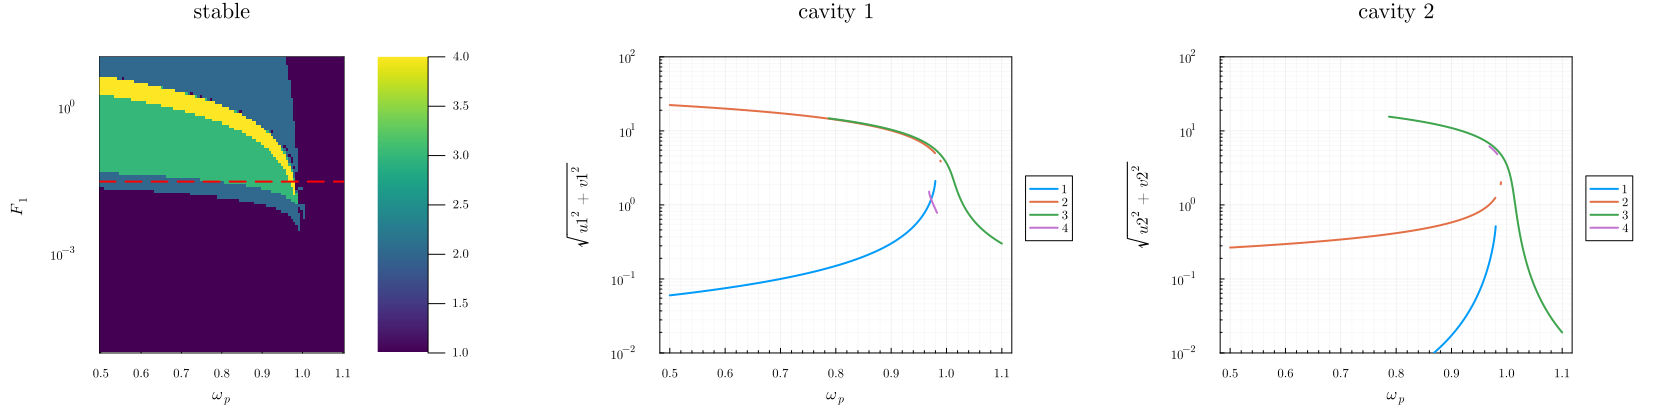

In [16]:
f_cut = 0.03; yscale = :log; class = "stable"; ymax=100

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box, yminorticks=10)
p2 = plot(result_ω1, y = "√(u1^2+v1^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-2,ymax), yminorticks=10, minorgrid=true, title="cavity 1")
p3 = plot(result_ω1, y = "√(u2^2+v2^2)", class=class, yscale=yscale, framestyle = :box, ylims=(1e-2,ymax), yminorticks=10, minorgrid=true, title="cavity 2")
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

### Phase plot

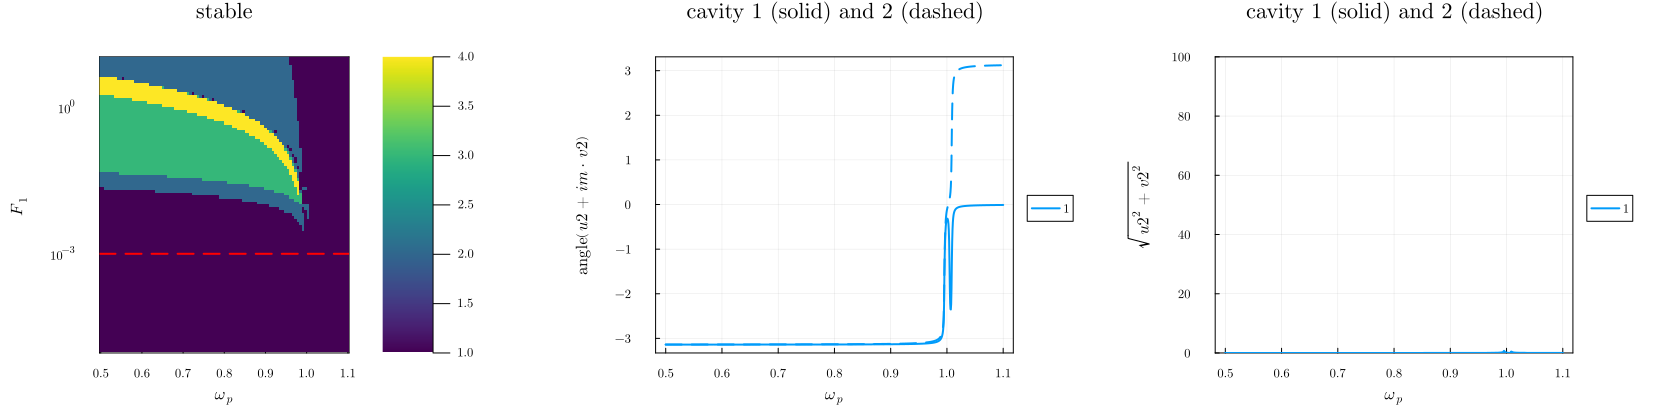

In [17]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log);
f_cut = 0.001; yscale = :linear; class = "stable"

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "angle(u1+im*v1)", class=class, yscale=yscale, framestyle = :box, title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "angle(u2+im*v2)", class=class, yscale=yscale, framestyle = :box, linestyle=:dash)
p3 = plot(result_ω1, y = "√(u1^2+v1^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "√(u2^2+v2^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), linestyle=:dash)
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

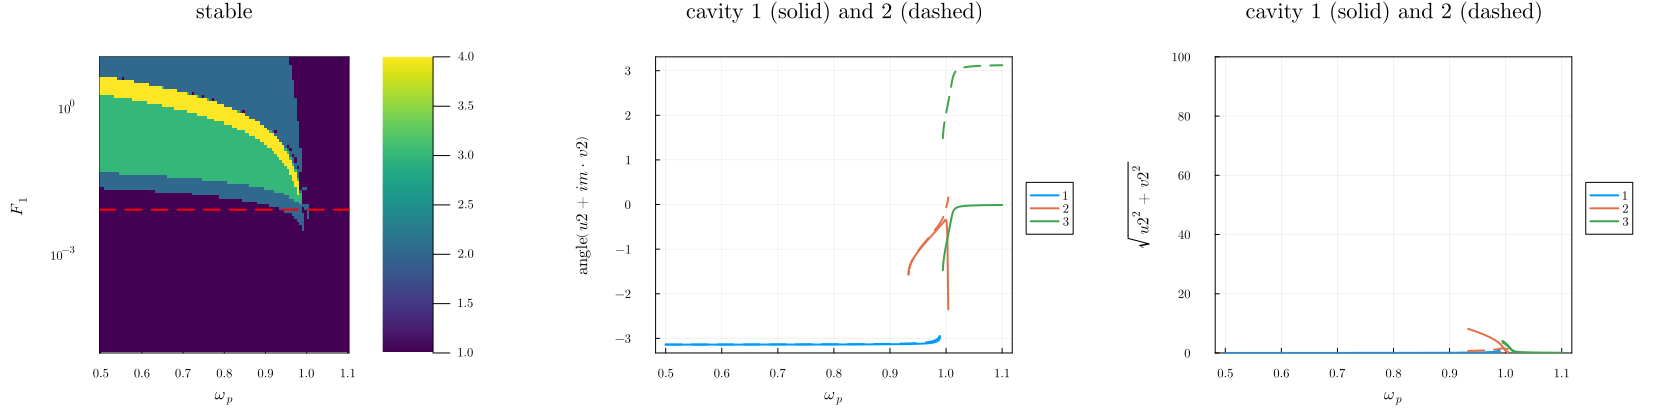

In [18]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log);
f_cut = 0.008; yscale = :linear; class = "stable"

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "angle(u1+im*v1)", class=class, yscale=yscale, framestyle = :box, title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "angle(u2+im*v2)", class=class, yscale=yscale, framestyle = :box, linestyle=:dash)
p3 = plot(result_ω1, y = "√(u1^2+v1^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "√(u2^2+v2^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), linestyle=:dash)
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

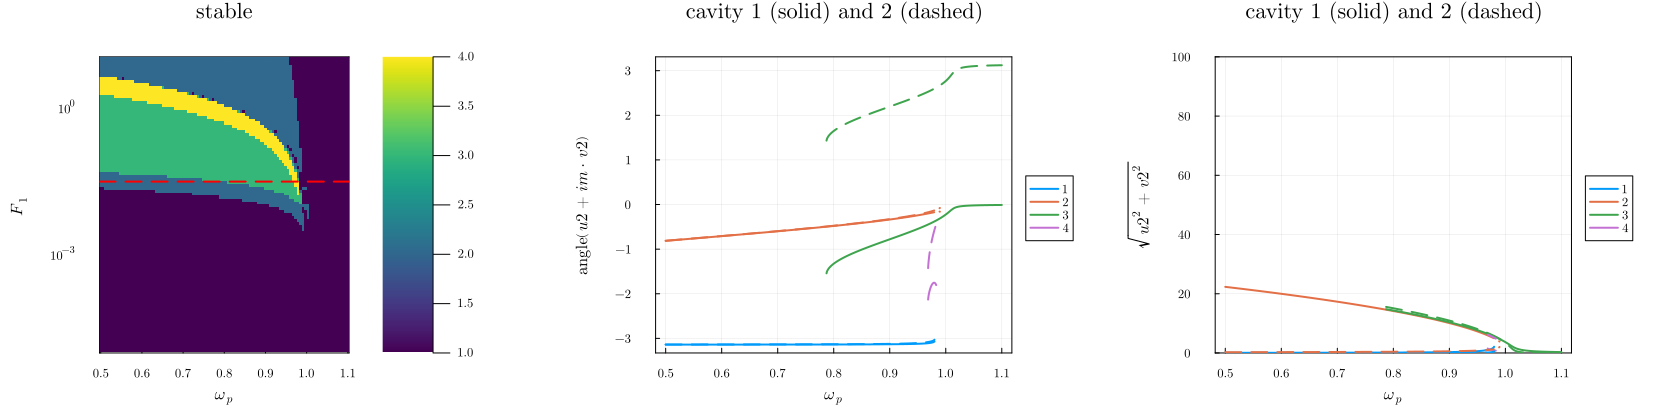

In [19]:
p_phase_stable = plot_phase_diagram(result_ωF, class="stable", title="stable", yaxis=:log);
f_cut = 0.03; yscale = :linear; class = "stable"

fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val,U_2 => U_2_val, J => J_val,  F_1 => f_cut)
varied = (ω_p => range(ω_p_min, ω_p_max, 1000))
result_ω1 = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true)

p1 = hline(p_phase_stable,[f_cut], color=:red, linestyle=:dash, linewidth=2, legend=false, framestyle = :box)
p2 = plot(result_ω1, y = "angle(u1+im*v1)", class=class, yscale=yscale, framestyle = :box, title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "angle(u2+im*v2)", class=class, yscale=yscale, framestyle = :box, linestyle=:dash)
p3 = plot(result_ω1, y = "√(u1^2+v1^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), title="cavity 1 (solid) and 2 (dashed)")
plot!(result_ω1, y = "√(u2^2+v2^2)", class=class, yscale=yscale, framestyle = :box, ylims=(0,ymax), linestyle=:dash)
plot(p1, p2, p3, layout = (1,3), size = 1.4.*(1200,300), margin = 10mm)

## Linear response 

### Attempt #1

In [33]:
max_force = 0.025

0.025

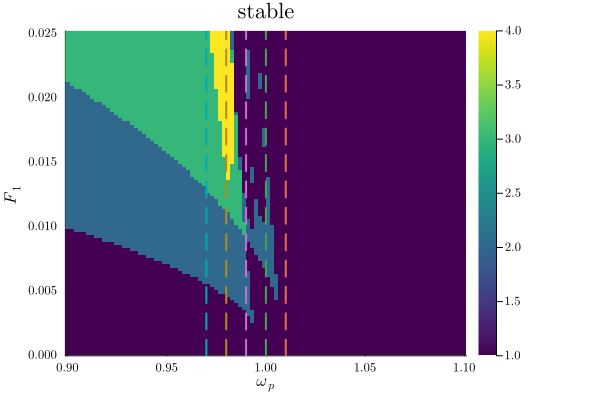

In [21]:
fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val, U_2 => U_2_val, J => J_val)
varied = (ω_p=> range(0.9, 1.1, 100), F_1 => range(1e-5,  0.025, 100))

# results
result_ωF = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true, random_warmup=false)
p1 = plot_phase_diagram(result_ωF, class="stable", title="stable")
vline!([1.01], linewidth=2, linestyle=:dash, label="")
vline!([1.0], linewidth=2, linestyle=:dash, label="")
vline!([0.99], linewidth=2, linestyle=:dash, label="")
vline!([0.98], linewidth=2, linestyle=:dash, label="")
vline!([0.97], linewidth=2, linestyle=:dash, label="")

In [76]:
anim = @animate for omega in range(0.9, 1.0, 20)
    fixed = (κ₁ => kappa_1, κ₂ => kappa_2, ω_1=> omega_1, ω_2=>omega_2, U_1 => U_1_val, U_2 => U_2_val, J => J_val, ω_p => omega)   # fixed parameters
    varied = F_1 => 10 .^range(-5,  0, 100)           # range of parameter values
    result = get_steady_states(MF_eqs, varied, fixed, show_progress=false, threading=true, random_warmup=false)

    p1 = plot_1D_solutions_branch(1, result; x="F_1", y="√(u1^2+v1^2)", label="", xscale=:log); p2 =plot_1D_solutions_branch(1, result; x="F_1", y="√(u2^2+v2^2)", label="", xscale=:log);
    followed_branches, _ = follow_branch(1, result, y="√(u2^2+v2^2)");
    p3 = plot_linear_response(result, x, followed_branches; Ω_range=range(0.8,1.1,500), switch_axis=true, yscale=:log, logscale=true, clims=(4,12))
    p4 = plot_linear_response(result, y, followed_branches; Ω_range=range(0.8,1.1,500), switch_axis=true, yscale=:log, logscale=true, clims=(4,12))
    plot(p1, p2, p3, p4, size=(1000,800), layout=(2,2), margin = 5mm, legend=false, plot_title=latexstring("ω_p = $(round(omega, sigdigits=4))"))
end

Animation("C:\\Users\\orjan\\AppData\\Local\\Temp\\jl_hCtfbk", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png", "000017.png", "000018.png", "000019.png", "000020.png"])

Plots.AnimatedGif("C:\\Users\\orjan\\AppData\\Local\\Temp\\jl_XCrGrU7uDI.gif")
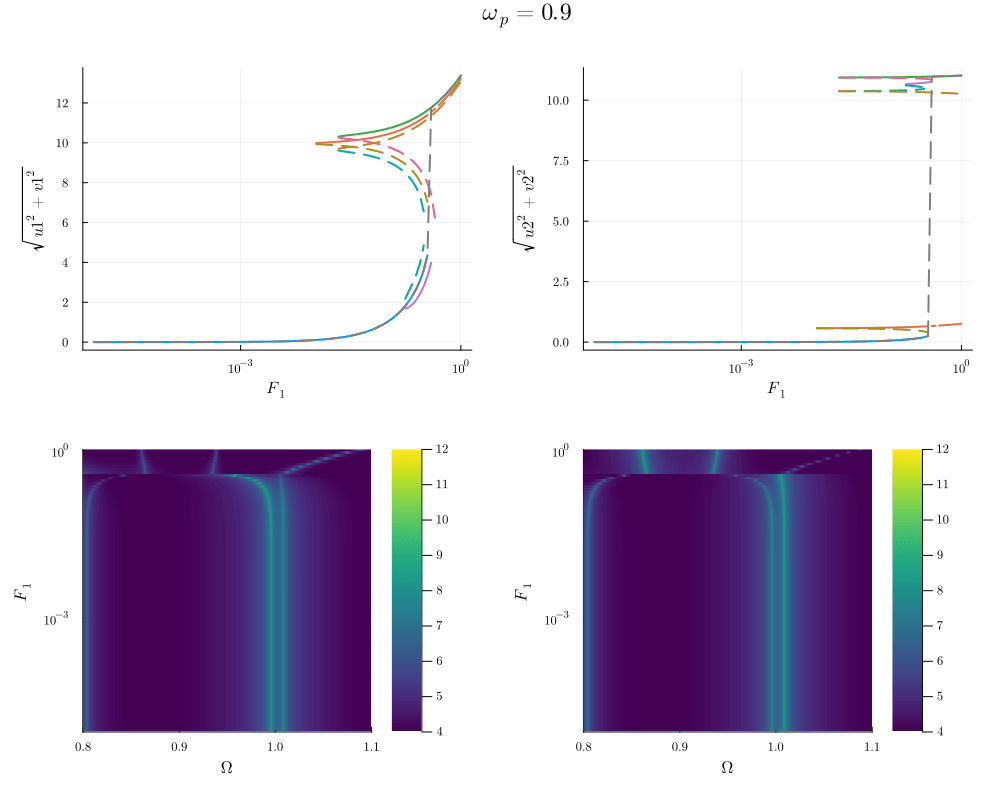

In [77]:
gif(anim, fps=1)